# Feedback Agent Notebook

This notebook is to create the initial version of our Feedback agent


TODO:
- Create a excel document with the columns needed -> done
- Create a piece of code to ingest the excel -> done
- Make the categorizer agent with a Structured Output + a Rationale -> done
- Make a workflow to ingest the entire document -> done
- Add agents -> Done
- Add a tool or method to send Slack messages
- Add langsmith for observability
- Split everything in a real project
- Provide infra

In [296]:
# Define a prompt for the classifier
prompt_classifier =(
"""
You are a feedback classification agent. Your task is to categorize user feedback messages about Insights recommendations into one of four categories.

Description of an Insight:
An Insight is a card that contains the following elements:
Primary Text: Text containing the title of the recommendation.
Secondary Text: Text containing the recommendation the user is encouraged to follow.
Image or Video: An image or video that accompanies the recommendation to enhance the user experience.
1-2 Calls to Action: Each card contains one to two buttons that take the user to external help or interest sites following the recommendation in the Secondary Text.

Categories:

Content Issues - Problems with the Insights content itself, including:
- Irrelevant content for the user in the Insight
- Incorrect or inaccurate information presented in the Insight about a feature or the product
- Images that don't match the content
- Any other content-related problems

Technical Issues - Technical problems with the Insight or its components, including:
- Broken CTAs (calls-to-action)
- Broken or missing images
- 404 errors
- Broken icons
- Non-playable videos
- Any other technical malfunctions

Rude Feedback - Messages that are:
- Contain offensive language like fucking, shit, etc.
- Provide no actionable feedback

Other - Any feedback that doesn't fit the above categories

Instructions:
Read the user's feedback message and respond with exactly one category name: "Technical Issues", "Content Issues", "Rude Feedback", or "Other". Do not include any explanation or additional text in your response.

IMPORTANT:
- The Technical Issues category is only for problems with the Insight or its components, not a feature or the product.
"""
)

In [297]:
#TODO: Add a template for the report
#TODO: Add explicit aspects to evaluate to prioritize the feedback

prompt_reporter = """
You are an expert customer service agent. Your job is to read, prioritize, and create urgent case reports from user feedback, which can then be evaluated by a human.

To achieve your goal, you must follow these steps:
1. You will receive a list of comments containing user feedback messages, a category defined by an AI agent for each message, and an explanation of why the AI ​​agent defined the category for that message.
2. You must read each message, category, and explanation one by one.
3. You must create a report that will be shared via Slack with the following elements:
    - The 5 most urgent messages from Category "Technical Issues" depending on their severity.
    - The 5 most urgent messages from Category "Content Issues" depending on their severity.
    - A quick summary of Categories "Rude Feedback" and "Other".
    - A funny invitation to the team to resolve issues and make improvements over this AI Agent making your own suggestions.

4. In the slack_message field, format the COMPLETE report using Slack markdown:
   - Always use an intro for the report
   - Use *bold* for emphasis and section headers
   - Use _italic_ for subtle emphasis
   - Use `code` format for user IDs and insight names
   - Use emoji (🔧, 📝, 😤, 🔍, 💬, etc.) for visual appeal
   - Use numbered lists for technical and content issues
   - Include all 5 technical issues and all 5 content issues with full details
   - Include the summaries for rude feedback and other feedback
   - Include the team message at the end
   - Use line breaks and section dividers (━━━) for readability
   - Make it ready to copy-paste directly into Slack
"""

In [298]:
# Define a structured output for the classifier
from pydantic import BaseModel, Field

class FeedbackCategory(BaseModel):
    """The category of the feedback"""
    category: str = Field(..., description="Category of the feedback")
    rationale: str = Field(..., description="Explantion why the category was chosen")
    

In [299]:
# Define the classifier agent
from langchain.agents import create_agent
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()  # Loads variables from .env into the environment

model_evaluator = ChatOpenAI(
    model="gpt-4.1",
    temperature=0.1,
    max_tokens=1000,
    timeout=30
)

agent_classifier = create_agent(
    model=model_evaluator,
    system_prompt=prompt_classifier,
    response_format=FeedbackCategory,
)

In [300]:
# Define a structured output for the reporter
from pydantic import BaseModel, Field
from typing import List

class UrgentFeedback(BaseModel):
    """Single urgent feedback item"""
    user_id: str = Field(description="The user ID")
    insight_type: str = Field(description="The type of the Insight")
    insight_name: str = Field(description="The name of the Insight Sub Type")
    product_line_name: str = Field(description="The product line name")
    feedback: str = Field(description="The feedback from the user")
    severity_reason: str = Field(description="Why this is urgent")

class FeedbackReport(BaseModel):
    """Complete feedback report"""
    technical_issues_top5: List[UrgentFeedback] = Field(
        description="Top 5 most urgent technical issues"
    )
    content_issues_top5: List[UrgentFeedback] = Field(
        description="Top 5 most urgent content issues"
    )
    rude_feedback_summary: str = Field(
        description="Brief summary of rude feedback"
    )
    other_summary: str = Field(
        description="Brief summary of other feedback"
    )
    intro_message: str = Field(
        description="Intro message for the report"
    )
    team_message: str = Field(
        description="Funny message to the team"
    )
    slack_message: str = Field(
        description="Complete report formatted for Slack using Slack markdown syntax (*bold*, _italic_, `code`, emoji). Include all sections with proper formatting and spacing."
    )

In [301]:
# Define the reporter agent
from langchain.agents import create_agent
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()  # Loads variables from .env into the environment

model_reporter = ChatOpenAI(
    model="gpt-4.1",
    temperature=0.1,
    max_tokens=2000,  
    timeout=30
)

#TODO: Add tool to send the report to Slack?
reporter_agent = create_agent(
    model=model_reporter,
    system_prompt=prompt_reporter,
    response_format=FeedbackReport,
)

In [302]:
from pydantic import BaseModel, Field
from typing import Optional

# Define a Pydantic model for the feedback data
class FeedbackItem(BaseModel):
    user_id: str = Field(description="The user ID")
    feedback: str = Field(description="The feedback from the user")
    insight_sub_type: str = Field(description="The sub type of the insight")
    insight_type: str = Field(description="The insight type")
    product_line_name: str = Field(description="The product line name")
    category: Optional[str] = Field(default=None, description="LLM-assigned category")
    rationale: Optional[str] = Field(default=None, description="LLM reasoning for category")

In [303]:
# Step 1: Define state
from langchain.messages import AnyMessage
from typing import List
from typing_extensions import TypedDict, Annotated
import operator

class MessagesState(TypedDict):
    """State for batch processing feedback"""
    ## messages: Annotated[list[AnyMessage], operator.add]
    feedback_items: List[FeedbackItem]  # All items to process
    classified_results: Annotated[List[FeedbackItem], operator.add]  # Accumulate results
    final_report: str # Final report to be sent to Slack
    node_calls: int

In [304]:
# Step 2: Define model nodes
# Step 2.1: Define the Data Ingestion node

def load_feedback_data(state: MessagesState):
    """Load the feedback data from the Excel file"""

    # Importing the excel file and getting the user feedback
    import pandas as pd

    # Read Excel file
    df = pd.read_excel('docs/feedback_insight_users_sep.xlsx')

    df_filtered = df[['User ID', 'Translated Comment', 'Insight Sub Type', 'Insight', 'Product Line Name']]

    # Convert DataFrame to list of Feedback objects
    feedback_list = [
        FeedbackItem(
            user_id=row['User ID'],
            feedback=row['Translated Comment'],
            insight_sub_type=row['Insight Sub Type'],
            insight_type=row['Insight'],
            product_line_name=row['Product Line Name']
        )
        for row in df_filtered.to_dict('records')
    ]

    print(f"✅ Loaded {len(feedback_list)} feedback items from Excel")

    # Print the list of feedback objects
    # for feedback in feedback_list:
    #     print(feedback)
    
    return {
        "feedback_items": feedback_list,
        "classified_results": []
    }

In [305]:
# Step 2.2: Define de Classifier node
from langchain.messages import AIMessage

def classify_comments(state: MessagesState):
    """Node with the classifier agent that classifies the feedback"""

    feedback_list = state["feedback_items"]
    classified_results = []

    for feedback in feedback_list:

        #TODO: Remove this
        # Temporary limit of 10 items
        if len(classified_results) >= 15:
             break

        inputs = {"messages": [{"role": "user", "content": feedback.feedback}]}
        response = agent_classifier.invoke(inputs)

        feedback.category = response["structured_response"].category
        feedback.rationale = response["structured_response"].rationale
    
        classified_results.append(feedback)

    print(f"Classified feedback list with {len(feedback_list)} items")

    return {
        "classified_results": classified_results,
        "node_calls": state.get('node_calls', 0) + 1
    }

In [306]:
# Step 2.3: Define the Prioritizer node
from typing import List, Dict

def create_report(state: MessagesState) -> dict:
    """Generate prioritized report from classified feedback"""
    
    classified_comments = state["classified_results"]
    
    # 1. Pre-process: Group by category
    categorized = {
        "Technical Issues": [],
        "Content Issues": [],
        "Rude Feedback": [],
        "Other": []
    }
    
    for comment in classified_comments:
        if comment.category in categorized:
            categorized[comment.category].append(comment)
    
    # 2. Format feedback concisely for the LLM
    def format_feedback_list(comments: List[FeedbackItem]) -> str:
        """Create compact format for LLM"""
        formatted = []
        for i, comment in enumerate(comments, 1):
            formatted.append(
                f"{i}. [User: {comment.user_id}] | "
                f"Product: {comment.product_line_name} | "
                f"Insight type: {comment.insight_type} | "
                f"Insight name: {comment.insight_sub_type} | "
                f"Feedback: \"{comment.feedback}\" | "
                f"Rationale: {comment.rationale}"
            )
        return "\n".join(formatted)
    
    # 3. Build the input message for the LLM
    input_message = f"""
    # CLASSIFIED USER FEEDBACK REPORT

    ## Technical Issues ({len(categorized['Technical Issues'])} comments)
    {format_feedback_list(categorized['Technical Issues']) if categorized['Technical Issues'] else "None"}

    ## Content Issues ({len(categorized['Content Issues'])} comments)
    {format_feedback_list(categorized['Content Issues']) if categorized['Content Issues'] else "None"}

    ## Rude Feedback ({len(categorized['Rude Feedback'])} comments)
    {format_feedback_list(categorized['Rude Feedback']) if categorized['Rude Feedback'] else "None"}

    ## Other ({len(categorized['Other'])} comments)
    {format_feedback_list(categorized['Other']) if categorized['Other'] else "None"}

    ---
    Please analyze this feedback and create the prioritized report as instructed.
    """
    
    # 4. Call the reporter agent with structured output
    inputs = {"messages": [{"role": "user", "content": input_message}]}
    response = reporter_agent.invoke(inputs)
    
    print("✅ Report generated successfully!")
    
    # 5. Return the report
    return {
        "final_report": response,  # Store the generated report
        "node_calls": state.get('node_calls', 0) + 1
    }

In [307]:
# Step 2.3: Export classified results to Excel
import pandas as pd
import os
from datetime import datetime

def export_classified_results(state: MessagesState):
    """Export classified feedback to Excel file"""
    
    classified_results = state["classified_results"]
    
    # Create output directory if it doesn't exist
    os.makedirs('output', exist_ok=True)
    
    # Convert to DataFrame
    data = []
    for item in classified_results:
        data.append({
            'User ID': item.user_id,
            'Feedback': item.feedback,
            'Insight Sub Type': item.insight_sub_type,
            'Insight Type': item.insight_type,
            'Product Line': item.product_line_name,
            'Category': item.category,
            'Rationale': item.rationale
        })
    
    df = pd.DataFrame(data)
    
    # Generate filename with timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'output/classified_feedback_{timestamp}.xlsx'
    
    # Export to Excel
    df.to_excel(filename, index=False)
    
    print(f"✅ Exported {len(classified_results)} classified items to: {filename}")
    
    return {
        "node_calls": state.get('node_calls', 0) + 1
    }


In [308]:
# Step 3: Build workflow
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("load_feedback_data", load_feedback_data)
workflow.add_node("classify_comments", classify_comments)
workflow.add_node("export_classified_results", export_classified_results)
workflow.add_node("create_report", create_report)

# Add edges 
workflow.add_edge(START, "load_feedback_data")
workflow.add_edge("load_feedback_data", "classify_comments")
workflow.add_edge("classify_comments", "export_classified_results")
workflow.add_edge("export_classified_results", "create_report")
workflow.add_edge("create_report", END)

# Compile the workflow
chain = workflow.compile()

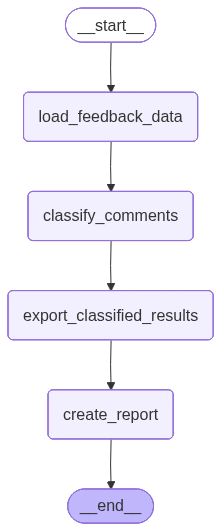

In [309]:
# Show the workflow
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

In [310]:
# Invoke the workflow with initial state
initial_state = {
    "feedback_items": [],
    "classified_results": [],
    "final_report": "",
    "llm_calls": 0
}

print("🚀 Starting feedback classification workflow...\n")
result = chain.invoke(initial_state)

print(f"\n✨ Workflow Complete!")
print(f"   Total items classified: {len(result['classified_results'])}")
print(f"   Total Node calls: {result['node_calls']}")

# for i, item in enumerate(result['classified_results'], 1):
#     print(f"\n--- Feedback #{i} ---")
#     print(f"User: {item.user_id}")
#     print(f"Comment: {item.feedback}")
#     print(f"Category: {item.category}")
#     print(f"Rationale: {item.rationale}")


🚀 Starting feedback classification workflow...

✅ Loaded 59 feedback items from Excel


/Users/raider737/Documents/ai_projects/feedback_agent_v1/.venv/lib/python3.14/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Classified feedback list with 59 items
✅ Exported 15 classified items to: output/classified_feedback_20251026_010948.xlsx
✅ Report generated successfully!

✨ Workflow Complete!
   Total items classified: 15
   Total Node calls: 3


In [311]:
# 📱 Get the Slack-ready message
print("="*80)
print("📱 SLACK MESSAGE (Ready to Copy & Paste)")
print("="*80)
print()

slack_message = result['final_report']['structured_response'].slack_message
print(slack_message)

print()
print("="*80)
print("✅ Copy the message above and paste it directly into Slack!")
print("="*80)



📱 SLACK MESSAGE (Ready to Copy & Paste)

*🚨 User Feedback Report: Urgent Issues & Insights 🚨*
Here’s a prioritized summary of the most pressing technical and content issues reported by users, plus a quick look at rude and miscellaneous feedback. Let’s keep our users happy and productive!

━━━
*🔧 Top 5 Most Urgent Technical Issues:*
1. `CH3SNRZFRACP` | *ACD* | `WHATS_NEW` - *IMAGE_ASYNC_2026*  
   _Feedback:_ "page inaccessible"  
   _Severity:_ The page is completely inaccessible, blocking users from accessing new features or information. This is a critical technical failure.
2. `LXJ5NE6Z79HD` | *ACD* | `COMMAND_RECOMMENDATION` - *DWGHISTORY*  
   _Feedback:_ "404 error: Link is invalid and cannot be viewed"  
   _Severity:_ A 404 error prevents users from accessing important command recommendations, indicating a broken or misconfigured link.
3. `BD323G88QM849JF3` | *RVT* | `FEATURE_RECOMMENDATION` - *WALLS_AUTO_JOIN_LOCK*  
   _Feedback:_ "We tried it and it doesn't work"  
   _Severi